# 1) Import Libraries


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Ensure plots are shown inline
%matplotlib inline

# 2) Data Loading and Exploration

Class distribution in the Training set:
187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


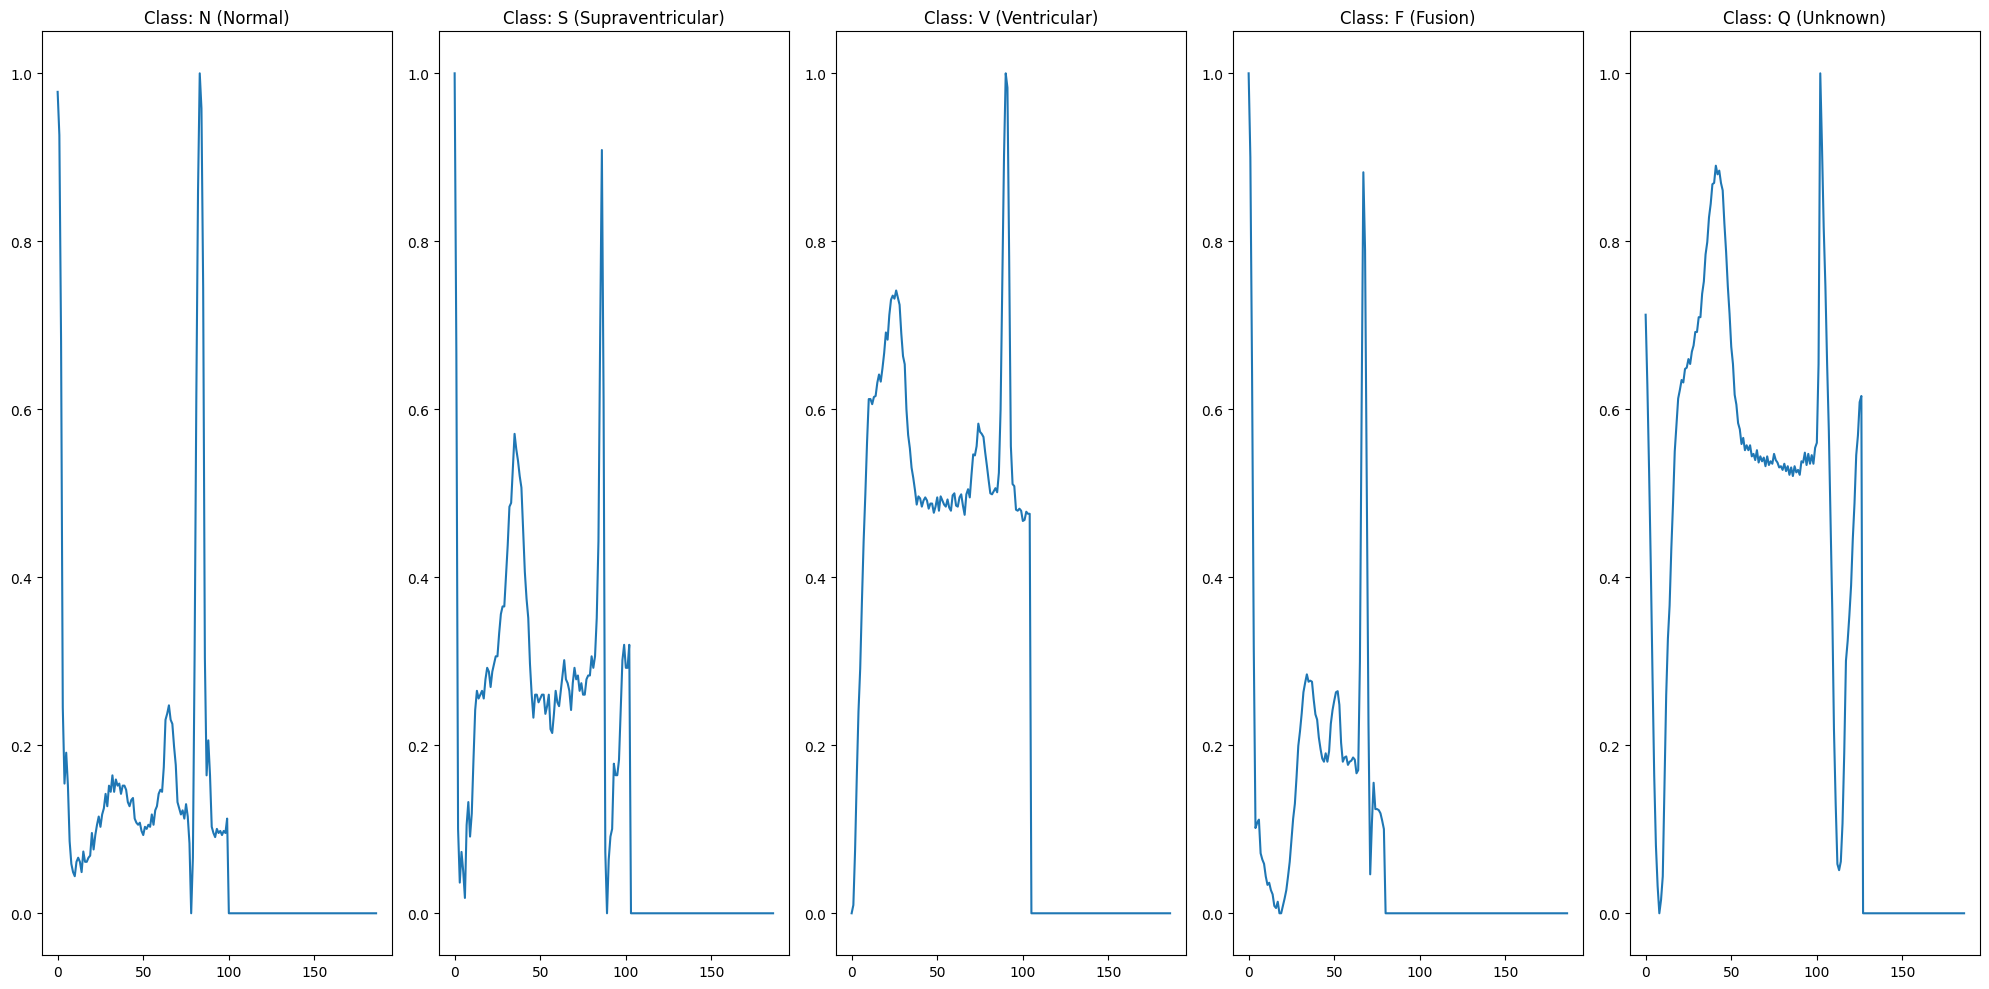

In [4]:
# Load the datasets
# Make sure mitbih_train.csv and mitbih_test.csv are in the same folder
train_df = pd.read_csv('mitbih_train.csv', header=None)
test_df = pd.read_csv('mitbih_test.csv', header=None)

# Display class distribution
print("Class distribution in the Training set:")
print(train_df[187].value_counts())

# Mapping labels to clinical names
class_names = {0: 'N (Normal)', 
               1: 'S (Supraventricular)', 
               2: 'V (Ventricular)', 
               3: 'F (Fusion)', 
               4: 'Q (Unknown)'}

# Visualize sample waveforms
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    sample = train_df[train_df[187] == i].iloc[0, :187]
    plt.plot(sample)
    plt.title(f"Class: {class_names[i]}")
plt.tight_layout()
plt.show()

# 3) Handling Data Imbalance (Resampling)

In [5]:
# Separate classes
df_0 = train_df[train_df[187] == 0]
df_1 = train_df[train_df[187] == 1]
df_2 = train_df[train_df[187] == 2]
df_3 = train_df[train_df[187] == 3]
df_4 = train_df[train_df[187] == 4]

# Resample to 20,000 samples per class
n_samples = 20000
df_1_upsampled = resample(df_1, replace=True, n_samples=n_samples, random_state=123)
df_2_upsampled = resample(df_2, replace=True, n_samples=n_samples, random_state=124)
df_3_upsampled = resample(df_3, replace=True, n_samples=n_samples, random_state=125)
df_4_upsampled = resample(df_4, replace=True, n_samples=n_samples, random_state=126)
df_0_downsampled = resample(df_0, replace=False, n_samples=n_samples, random_state=127)

# Merge back into a balanced training set
train_balanced = pd.concat([df_0_downsampled, df_1_upsampled, df_2_upsampled, df_3_upsampled, df_4_upsampled])

# Prepare X and y
X_train = train_balanced.iloc[:, :187].values
y_train = train_balanced.iloc[:, 187].values
X_test = test_df.iloc[:, :187].values
y_test = test_df.iloc[:, 187].values

# Reshape for 1D CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# One-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print("Final Training Shape:", X_train.shape)

Final Training Shape: (100000, 187, 1)


# 4)  Building Model (1D CNN)

In [6]:
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(187, 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Ta Quang Dung\ML_MEDICINE\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 185, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 185, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 92, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 90, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 45, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       737,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 763,781 (2.91 MB)

 Trainable params: 763,397 (2.91 MB)

 Non-trainable params: 384 (1.50 KB)

# 5) Model Training

In [7]:
# Using EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop])

Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 59s 17ms/step - accuracy: 0.8968 - loss: 0.2973 - val_accuracy: 0.9165 - val_loss: 0.2369
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - accuracy: 0.9562 - loss: 0.1240 - val_accuracy: 0.9338 - val_loss: 0.2000
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 55s 18ms/step - accuracy: 0.9700 - loss: 0.0878 - val_accuracy: 0.9652 - val_loss: 0.1290
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 78s 16ms/step - accuracy: 0.9774 - loss: 0.0672 - val_accuracy: 0.9527 - val_loss: 0.1928
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 55s 17ms/step - accuracy: 0.9817 - loss: 0.0554 - val_accuracy: 0.9537 - val_loss: 0.1846
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 57s 18ms/step - accuracy: 0.9833 - loss: 0.0505 - val_accuracy: 0.9667 - val_loss: 0.2043
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 60s 19ms/step - accuracy: 0.9865 - loss: 0.0422 - val_accuracy: 0.9702 - val_loss: 0.1518
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step - accuracy: 0.9883 -

# 6) Evaluation and Results

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

--- CLASSIFICATION REPORT ---
                      precision    recall  f1-score   support

          N (Normal)       0.99      0.97      0.98     18118
S (Supraventricular)       0.59      0.80      0.68       556
     V (Ventricular)       0.89      0.93      0.91      1448
          F (Fusion)       0.63      0.89      0.74       162
         Q (Unknown)       0.99      0.97      0.98      1608

            accuracy                           0.97     21892
           macro avg       0.82      0.91      0.86     21892
        weighted avg       0.97      0.97      0.97     21892



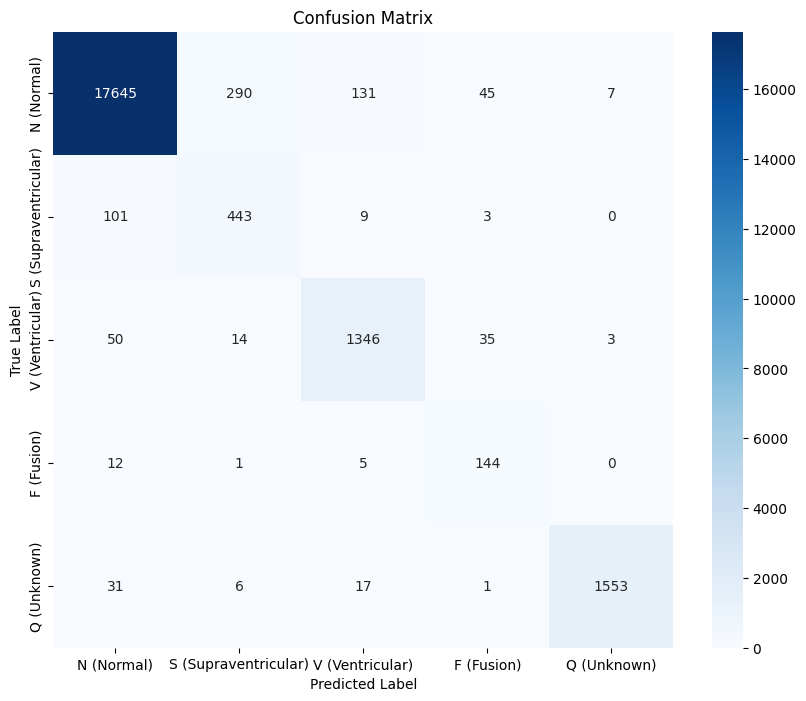

In [9]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print Classification Report
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_true, y_pred_classes, target_names=list(class_names.values())))

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d', cmap='Blues',
            xticklabels=list(class_names.values()), yticklabels=list(class_names.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()